<center> <h1>Food Classification and Calories Estimation</h1></center>

Develop a model that can accurately recognize food items from images and estimate their calorie content, enabling users to track their dietary intake and make informed food choices.

Dataset :- https://www.kaggle.com/dansbecker/food-101

In [1]:
import tensorflow as tf
import matplotlib.image as img
%matplotlib inline
import numpy as np
from collections import defaultdict
import collections
from shutil import copy
from shutil import copytree, rmtree
import tensorflow.keras.backend as K
from tensorflow.keras.models import load_model
from tensorflow.keras.preprocessing import image
import matplotlib.pyplot as plt
import numpy as np
import os
import random
import tensorflow as tf
import tensorflow.keras.backend as K
from tensorflow.keras import regularizers
from tensorflow.keras.applications.inception_v3 import InceptionV3
from tensorflow.keras.models import Sequential, Model
from tensorflow.keras.layers import Dense, Dropout, Activation, Flatten
from tensorflow.keras.layers import Convolution2D, MaxPooling2D, ZeroPadding2D, GlobalAveragePooling2D, AveragePooling2D
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.callbacks import ModelCheckpoint, CSVLogger
from tensorflow.keras.optimizers import SGD
from tensorflow.keras.regularizers import l2
from tensorflow import keras
from tensorflow.keras import models
import cv2

In [2]:
# Check if GPU is enabled
print(tf.__version__)
print(tf.test.gpu_device_name())

2.15.0



In [3]:
# Helper function to download data and extract
def get_data_extract():
  if "food-101" in os.listdir():
    print("Dataset already exists")
  else:
    print("Downloading the data...")
    !wget http://data.vision.ee.ethz.ch/cvl/food-101.tar.gz
    print("Dataset downloaded!")
    print("Extracting data..")
    !tar xzvf food-101.tar.gz
    print("Extraction done!")

* **Commented the below cell as the Food-101 dataset is available from Kaggle Datasets and need not be downloaded..**

In [4]:
# Download data and extract it to folder

get_data_extract()

Streaming output truncated to the last 5000 lines.
food-101/images/cannoli/1767088.jpg
food-101/images/cannoli/3201965.jpg
food-101/images/cannoli/3778102.jpg
food-101/images/cannoli/2674065.jpg
food-101/images/cannoli/1169899.jpg
food-101/images/cannoli/1378086.jpg
food-101/images/cannoli/803909.jpg
food-101/images/cannoli/1067240.jpg
food-101/images/cannoli/3002709.jpg
food-101/images/cannoli/2612632.jpg
food-101/images/cannoli/3627612.jpg
food-101/images/cannoli/1798703.jpg
food-101/images/cannoli/560632.jpg
food-101/images/cannoli/512468.jpg
food-101/images/cannoli/2331523.jpg
food-101/images/cannoli/3118302.jpg
food-101/images/cannoli/1499412.jpg
food-101/images/cannoli/1557459.jpg
food-101/images/cannoli/146566.jpg
food-101/images/cannoli/96922.jpg
food-101/images/cannoli/1699562.jpg
food-101/images/cannoli/730051.jpg
food-101/images/cannoli/2177977.jpg
food-101/images/cannoli/2767028.jpg
food-101/images/cannoli/6564.jpg
food-101/images/cannoli/553447.jpg
food-101/images/cannoli/

### **Understand dataset structure and files**

In [ ]:
# Check the extracted dataset folder
!ls food-101/

images	license_agreement.txt  meta  README.txt


In [ ]:
os.listdir('food-101/images')

['clam_chowder',
 'tacos',
 'french_toast',
 'risotto',
 'omelette',
 'garlic_bread',
 'oysters',
 'creme_brulee',
 'frozen_yogurt',
 'nachos',
 'grilled_cheese_sandwich',
 'cannoli',
 'chicken_quesadilla',
 'dumplings',
 'pulled_pork_sandwich',
 'spaghetti_carbonara',
 'eggs_benedict',
 'shrimp_and_grits',
 'macaroni_and_cheese',
 'croque_madame',
 'waffles',
 'prime_rib',
 'breakfast_burrito',
 'cup_cakes',
 'edamame',
 'lasagna',
 'tiramisu',
 'onion_rings',
 'lobster_roll_sandwich',
 'scallops',
 'bruschetta',
 'macarons',
 'ramen',
 'beignets',
 'spring_rolls',
 'chocolate_cake',
 'seaweed_salad',
 'beet_salad',
 'sashimi',
 'red_velvet_cake',
 'lobster_bisque',
 'french_onion_soup',
 'hamburger',
 'guacamole',
 'takoyaki',
 'huevos_rancheros',
 'deviled_eggs',
 'samosa',
 'sushi',
 'greek_salad',
 'fish_and_chips',
 'fried_rice',
 'bibimbap',
 'tuna_tartare',
 'pho',
 'baklava',
 'pad_thai',
 'beef_carpaccio',
 'mussels',
 'panna_cotta',
 'club_sandwich',
 'escargots',
 'cheese_p

In [ ]:
os.listdir('food-101/meta')

['test.txt',
 'classes.txt',
 'labels.txt',
 'train.txt',
 'test.json',
 'train.json']

In [ ]:
!head food-101/meta/train.txt

apple_pie/1005649
apple_pie/1014775
apple_pie/1026328
apple_pie/1028787
apple_pie/1043283
apple_pie/1050519
apple_pie/1057749
apple_pie/1057810
apple_pie/1072416
apple_pie/1074856


In [ ]:
!head food-101/meta/classes.txt

apple_pie
baby_back_ribs
baklava
beef_carpaccio
beef_tartare
beet_salad
beignets
bibimbap
bread_pudding
breakfast_burrito


### **Visualize random image from each of the 101 classes**

In [ ]:
# Visualize the data, showing one image per class from 101 classes
rows = 17
cols = 6
fig, ax = plt.subplots(rows, cols, figsize=(25,25))
fig.suptitle("Showing one random image from each class", y=1.05, fontsize=24) # Adding  y=1.05, fontsize=24 helped me fix the suptitle overlapping with axes issue
data_dir = "food-101/images/"
foods_sorted = sorted(os.listdir(data_dir))
food_id = 0
for i in range(rows):
  for j in range(cols):
    try:
      food_selected = foods_sorted[food_id]
      food_id += 1
    except:
      break
    if food_selected == '.DS_Store':
        continue
    food_selected_images = os.listdir(os.path.join(data_dir,food_selected)) # returns the list of all files present in each food category
    food_selected_random = np.random.choice(food_selected_images) # picks one food item from the list as choice, takes a list and returns one random item
    img = plt.imread(os.path.join(data_dir,food_selected, food_selected_random))
    ax[i][j].imshow(img)
    ax[i][j].set_title(food_selected, pad = 10)

plt.setp(ax, xticks=[],yticks=[])
plt.tight_layout()
# https://matplotlib.org/users/tight_layout_guide.html


### **Split the image data into train and test using train.txt and test.txt**

In [8]:
# Helper method to split dataset into train and test folders
def prepare_data(filepath, src,dest):
  classes_images = defaultdict(list)
  with open(filepath, 'r') as txt:
      paths = [read.strip() for read in txt.readlines()]
      for p in paths:
        food = p.split('/')
        classes_images[food[0]].append(food[1] + '.jpg')

  for food in classes_images.keys():
    print("\nCopying images into ",food)
    if not os.path.exists(os.path.join(dest,food)):
      os.makedirs(os.path.join(dest,food))
    for i in classes_images[food]:
      copy(os.path.join(src,food,i), os.path.join(dest,food,i))
  print("Copying Done!")

In [9]:
# Prepare train dataset by copying images from food-101/images to food-101/train using the file train.txt
print("Creating train data...")
prepare_data('food-101/meta/train.txt', 'food-101/images', 'train')

Creating train data...

Copying images into  apple_pie

Copying images into  baby_back_ribs

Copying images into  baklava

Copying images into  beef_carpaccio

Copying images into  beef_tartare

Copying images into  beet_salad

Copying images into  beignets

Copying images into  bibimbap

Copying images into  bread_pudding

Copying images into  breakfast_burrito

Copying images into  bruschetta

Copying images into  caesar_salad

Copying images into  cannoli

Copying images into  caprese_salad

Copying images into  carrot_cake

Copying images into  ceviche

Copying images into  cheesecake

Copying images into  cheese_plate

Copying images into  chicken_curry

Copying images into  chicken_quesadilla

Copying images into  chicken_wings

Copying images into  chocolate_cake

Copying images into  chocolate_mousse

Copying images into  churros

Copying images into  clam_chowder

Copying images into  club_sandwich

Copying images into  crab_cakes

Copying images into  creme_brulee

Copying im

In [10]:
# Prepare test data by copying images from food-101/images to food-101/test using the file test.txt
print("Creating test data...")
prepare_data('food-101/meta/test.txt', 'food-101/images', 'test')

Creating test data...

Copying images into  apple_pie

Copying images into  baby_back_ribs

Copying images into  baklava

Copying images into  beef_carpaccio

Copying images into  beef_tartare

Copying images into  beet_salad

Copying images into  beignets

Copying images into  bibimbap

Copying images into  bread_pudding

Copying images into  breakfast_burrito

Copying images into  bruschetta

Copying images into  caesar_salad

Copying images into  cannoli

Copying images into  caprese_salad

Copying images into  carrot_cake

Copying images into  ceviche

Copying images into  cheesecake

Copying images into  cheese_plate

Copying images into  chicken_curry

Copying images into  chicken_quesadilla

Copying images into  chicken_wings

Copying images into  chocolate_cake

Copying images into  chocolate_mousse

Copying images into  churros

Copying images into  clam_chowder

Copying images into  club_sandwich

Copying images into  crab_cakes

Copying images into  creme_brulee

Copying ima

In [ ]:
# Check how many files are in the train folder
print("Total number of samples in train folder")
!find train -type d -or -type f -printf '.' | wc -c

Total number of samples in train folder
75750


In [ ]:
# Check how many files are in the test folder
print("Total number of samples in test folder")
!find test -type d -or -type f -printf '.' | wc -c

Total number of samples in test folder
25250


In [ ]:
os.chdir('/')

### **Create a subset of data with few classes(3) - train_mini and test_mini for experimenting**

In [ ]:
foods_sorted

['apple_pie',
 'baby_back_ribs',
 'baklava',
 'beef_carpaccio',
 'beef_tartare',
 'beet_salad',
 'beignets',
 'bibimbap',
 'bread_pudding',
 'breakfast_burrito',
 'bruschetta',
 'caesar_salad',
 'cannoli',
 'caprese_salad',
 'carrot_cake',
 'ceviche',
 'cheese_plate',
 'cheesecake',
 'chicken_curry',
 'chicken_quesadilla',
 'chicken_wings',
 'chocolate_cake',
 'chocolate_mousse',
 'churros',
 'clam_chowder',
 'club_sandwich',
 'crab_cakes',
 'creme_brulee',
 'croque_madame',
 'cup_cakes',
 'deviled_eggs',
 'donuts',
 'dumplings',
 'edamame',
 'eggs_benedict',
 'escargots',
 'falafel',
 'filet_mignon',
 'fish_and_chips',
 'foie_gras',
 'french_fries',
 'french_onion_soup',
 'french_toast',
 'fried_calamari',
 'fried_rice',
 'frozen_yogurt',
 'garlic_bread',
 'gnocchi',
 'greek_salad',
 'grilled_cheese_sandwich',
 'grilled_salmon',
 'guacamole',
 'gyoza',
 'hamburger',
 'hot_and_sour_soup',
 'hot_dog',
 'huevos_rancheros',
 'hummus',
 'ice_cream',
 'lasagna',
 'lobster_bisque',
 'lobster

In [5]:
# Helper method to create train_mini and test_mini data samples
def dataset_mini(food_list, src, dest):
  if os.path.exists(dest):
    rmtree(dest) # removing dataset_mini(if it already exists) folders so that we will have only the classes that we want
  os.makedirs(dest)
  for food_item in food_list :
    print("Copying images into",food_item)
    copytree(os.path.join(src,food_item), os.path.join(dest,food_item))


In [6]:
# picking 3 food items and generating separate data folders for the same
food_list = ['apple_pie','pizza','omelette']
src_train = 'train'
dest_train = 'train_mini/'
src_test = 'test'
dest_test = 'test_mini/'

In [11]:
print("Creating train data folder with new classes")
dataset_mini(food_list, src_train, dest_train)

Creating train data folder with new classes
Copying images into apple_pie
Copying images into pizza
Copying images into omelette


In [12]:
print("Total number of samples in train folder")

!find train_mini -type d -or -type f -printf '.' | wc -c

Total number of samples in train folder
2250


In [13]:
print("Creating test data folder with new classes")
dataset_mini(food_list, src_test, dest_test)

Creating test data folder with new classes
Copying images into apple_pie
Copying images into pizza
Copying images into omelette


In [14]:
print("Total number of samples in test folder")
!find test_mini -type d -or -type f -printf '.' | wc -c

Total number of samples in test folder
750


### **Fine tune ResNet50 Pretrained model using Food 101 dataset**

In [ ]:
from tensorflow.keras.applications.resnet50 import ResNet50

K.clear_session()
n_classes = 3
img_width, img_height = 224, 224
train_data_dir = 'train_mini'
validation_data_dir = 'test_mini'
nb_train_samples = 2250 #75750
nb_validation_samples = 750 #25250
batch_size = 16

train_datagen = ImageDataGenerator(
    rescale=1. / 255,
    shear_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True)

test_datagen = ImageDataGenerator(rescale=1. / 255)

train_generator = train_datagen.flow_from_directory(
    train_data_dir,
    target_size=(img_height, img_width),
    batch_size=batch_size,
    class_mode='categorical')

validation_generator = test_datagen.flow_from_directory(
    validation_data_dir,
    target_size=(img_height, img_width),
    batch_size=batch_size,
    class_mode='categorical')


resnet50 = ResNet50(weights='imagenet', include_top=False)
x = resnet50.output
x = GlobalAveragePooling2D()(x)
x = Dense(128,activation='relu')(x)
x = Dropout(0.2)(x)

predictions = Dense(3,kernel_regularizer=regularizers.l2(0.005), activation='softmax')(x)

model = Model(inputs=resnet50.input, outputs=predictions)
model.compile(optimizer=SGD(lr=0.0001, momentum=0.9), loss='categorical_crossentropy', metrics=['accuracy'])
checkpointer = ModelCheckpoint(filepath='best_model_3class.hdf5', verbose=1, save_best_only=True)
csv_logger = CSVLogger('history_3class.log')

history = model.fit_generator(train_generator,
                    steps_per_epoch = nb_train_samples // batch_size,
                    validation_data=validation_generator,
                    validation_steps=nb_validation_samples // batch_size,
                    epochs=30,
                    verbose=1,
                    callbacks=[csv_logger, checkpointer])

model.save('model_trained_3class.hdf5')

Found 2250 images belonging to 3 classes.
Found 750 images belonging to 3 classes.
94765736/94765736 [==============================] - 0s 0us/step


<ipython-input-44-b7d4e22e46c2>:46: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  history = model.fit_generator(train_generator,


Epoch 1/30
140/140 [==============================] - ETA: 0s - loss: 0.8749 - accuracy: 0.6415
Epoch 1: val_loss improved from inf to 1.20909, saving model to best_model_3class.hdf5


/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


140/140 [==============================] - 75s 346ms/step - loss: 0.8749 - accuracy: 0.6415 - val_loss: 1.2091 - val_accuracy: 0.3370
Epoch 2/30
140/140 [==============================] - ETA: 0s - loss: 0.6828 - accuracy: 0.7314
Epoch 2: val_loss did not improve from 1.20909
140/140 [==============================] - 46s 325ms/step - loss: 0.6828 - accuracy: 0.7314 - val_loss: 3.1858 - val_accuracy: 0.3315
Epoch 3/30
140/140 [==============================] - ETA: 0s - loss: 0.5741 - accuracy: 0.7950
Epoch 3: val_loss did not improve from 1.20909
140/140 [==============================] - 43s 307ms/step - loss: 0.5741 - accuracy: 0.7950 - val_loss: 3.0153 - val_accuracy: 0.2582
Epoch 4/30
140/140 [==============================] - ETA: 0s - loss: 0.4690 - accuracy: 0.8330
Epoch 4: val_loss did not improve from 1.20909
140/140 [==============================] - 44s 313ms/step - loss: 0.4690 - accuracy: 0.8330 - val_loss: 2.4278 - val_accuracy: 0.3370
Epoch 5/30
140/140 [===============

In [ ]:
class_map_3 = train_generator.class_indices
class_map_3

{'apple_pie': 0, 'omelette': 1, 'pizza': 2}

### **Visualize the accuracy and loss plots**

In [ ]:
def plot_accuracy(history,title):
    plt.title(title)
    plt.plot(history.history['accuracy'])
    plt.plot(history.history['val_accuracy'])
    plt.ylabel('accuracy')
    plt.xlabel('epoch')
    plt.legend(['train_accuracy', 'validation_accuracy'], loc='best')
    plt.show()
def plot_loss(history,title):
    plt.title(title)
    plt.plot(history.history['loss'])
    plt.plot(history.history['val_loss'])
    plt.ylabel('loss')
    plt.xlabel('epoch')
    plt.legend(['train_loss', 'validation_loss'], loc='best')
    plt.show()

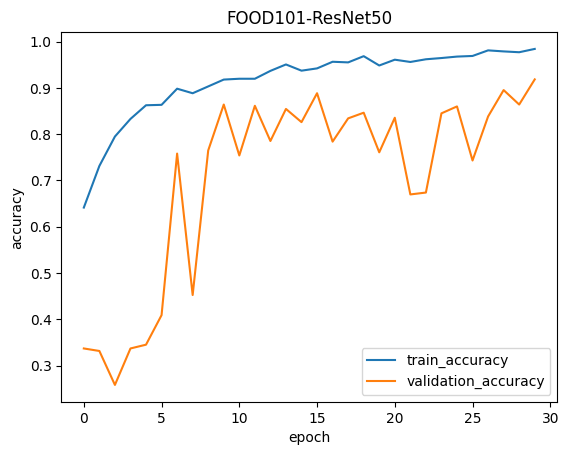

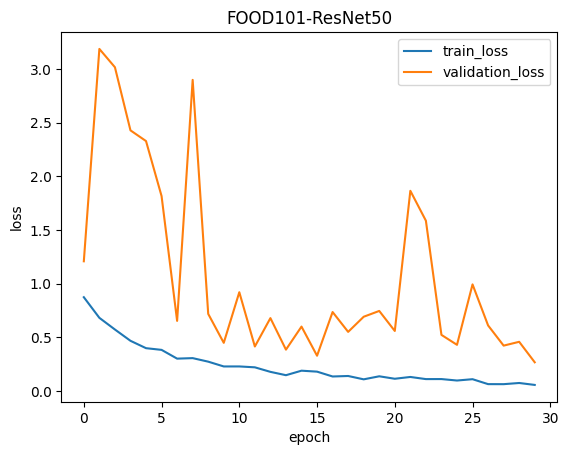

In [ ]:
from tensorflow.keras.applications.resnet50 import ResNet50

plot_accuracy(history,'FOOD101-ResNet50')
plot_loss(history,'FOOD101-ResNet50')

### **Predicting classes for new images from internet using the best trained model**

In [ ]:
%%time
# Loading the best saved model to make predictions
K.clear_session()
model_best = load_model('best_model_3class.hdf5',compile = False)

CPU times: user 2.34 s, sys: 92.8 ms, total: 2.44 s
Wall time: 2.48 s


In [ ]:
def predict_class(model, images, show = True):
  for img in images:
    img = image.load_img(img, target_size=(224, 224))
    img = image.img_to_array(img)
    img = np.expand_dims(img, axis=0)
    img /= 255.

    pred = model.predict(img)
    index = np.argmax(pred)
    food_list.sort()
    pred_value = food_list[index]
    if show:
        plt.imshow(img[0])
        plt.axis('off')
        plt.title(pred_value)
        plt.show()

1/1 [==============================] - 0s 22ms/step


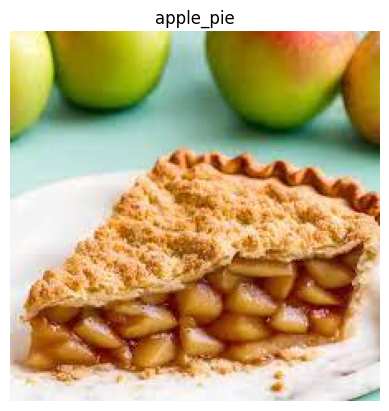

1/1 [==============================] - 0s 23ms/step


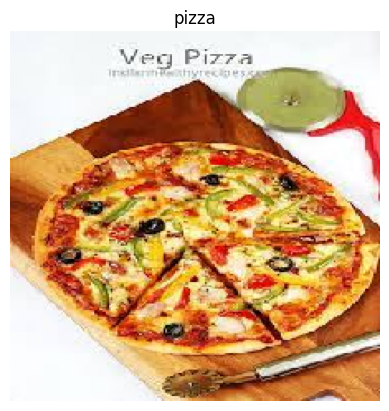

1/1 [==============================] - 0s 28ms/step


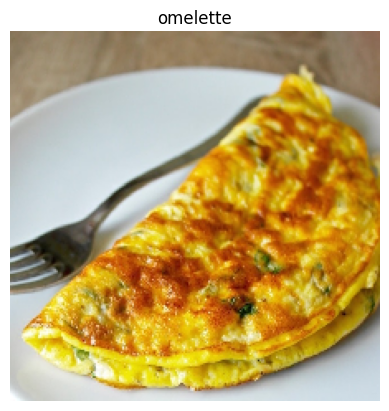

In [ ]:
# Make a list of downloaded images and test the trained model
images = []
images.append('/content/applepie.jpeg')
images.append('/content/pizza.jpeg')
images.append('/content/omelette.jpg')
predict_class(model_best, images, True)

### **Fine tune ResNet50 model with 11 classes of data**

In [ ]:
# Helper function to select n random food classes
def pick_n_random_classes(n):
  food_list = []
  random_food_indices = random.sample(range(len(foods_sorted)),n) # We are picking n random food classes
  for i in random_food_indices:
    food_list.append(foods_sorted[i])
  food_list.sort()
  return food_list

In [ ]:
# Lets try with more classes than just 3. Also, this time lets randomly pick the food classes
n = 11
food_list = pick_n_random_classes(n)
food_list = ['apple_pie', 'beef_carpaccio', 'bibimbap', 'cup_cakes', 'foie_gras', 'french_fries', 'garlic_bread', 'pizza', 'spring_rolls', 'spaghetti_carbonara', 'strawberry_shortcake']
print("These are the randomly picked food classes we will be training the model on...\n", food_list)

These are the randomly picked food classes we will be training the model on...
 ['apple_pie', 'beef_carpaccio', 'bibimbap', 'cup_cakes', 'foie_gras', 'french_fries', 'garlic_bread', 'pizza', 'spring_rolls', 'spaghetti_carbonara', 'strawberry_shortcake']


In [ ]:
# Create the new data subset of n classes
print("Creating training data folder with new classes...")
dataset_mini(food_list, src_train, dest_train)

Creating training data folder with new classes...
Copying images into apple_pie
Copying images into beef_carpaccio
Copying images into bibimbap
Copying images into cup_cakes
Copying images into foie_gras
Copying images into french_fries
Copying images into garlic_bread
Copying images into pizza
Copying images into spring_rolls
Copying images into spaghetti_carbonara
Copying images into strawberry_shortcake


In [ ]:
print("Total number of samples in train folder")
!find train_mini/ -type d -or -type f -printf '.' | wc -c

Total number of samples in train folder
8250


In [ ]:
print("Creating test data folder with new classes")
dataset_mini(food_list, src_test, dest_test)

Creating test data folder with new classes
Copying images into apple_pie
Copying images into beef_carpaccio
Copying images into bibimbap
Copying images into cup_cakes
Copying images into foie_gras
Copying images into french_fries
Copying images into garlic_bread
Copying images into pizza
Copying images into spring_rolls
Copying images into spaghetti_carbonara
Copying images into strawberry_shortcake


In [ ]:
print("Total number of samples in test folder")
!find test_mini/ -type d -or -type f -printf '.' | wc -c

Total number of samples in test folder
2750


In [ ]:
# Let's use a pretrained Inceptionv3 model on subset of data with 11 food classes
K.clear_session()

n_classes = n
img_width, img_height = 224, 224
train_data_dir = 'train_mini'
validation_data_dir = 'test_mini'
nb_train_samples = 8250 #75750
nb_validation_samples = 2750 #25250
batch_size = 16

train_datagen = ImageDataGenerator(
    rescale=1. / 255,
    shear_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True)

test_datagen = ImageDataGenerator(rescale=1. / 255)

train_generator = train_datagen.flow_from_directory(
    train_data_dir,
    target_size=(img_height, img_width),
    batch_size=batch_size,
    class_mode='categorical')

validation_generator = test_datagen.flow_from_directory(
    validation_data_dir,
    target_size=(img_height, img_width),
    batch_size=batch_size,
    class_mode='categorical')


resnet50 = ResNet50(weights='imagenet', include_top=False)
x = resnet50.output
x = GlobalAveragePooling2D()(x)
x = Dense(128,activation='relu')(x)
x = Dropout(0.2)(x)

predictions = Dense(n,kernel_regularizer=regularizers.l2(0.005), activation='softmax')(x)

model = Model(inputs=resnet50.input, outputs=predictions)
model.compile(optimizer=SGD(lr=0.0001, momentum=0.9), loss='categorical_crossentropy', metrics=['accuracy'])
checkpointer = ModelCheckpoint(filepath='best_model_11class.hdf5', verbose=1, save_best_only=True)
csv_logger = CSVLogger('history_11class.log')

history_11class = model.fit_generator(train_generator,
                    steps_per_epoch = nb_train_samples // batch_size,
                    validation_data=validation_generator,
                    validation_steps=nb_validation_samples // batch_size,
                    epochs=30,
                    verbose=1,
                    callbacks=[csv_logger, checkpointer])

model.save('model_trained_11class.hdf5')

Found 8250 images belonging to 11 classes.
Found 2750 images belonging to 11 classes.


<ipython-input-82-5e8bedf55f6d>:46: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  history_11class = model.fit_generator(train_generator,


Epoch 1/30
515/515 [==============================] - ETA: 0s - loss: 1.5216 - accuracy: 0.5407
Epoch 1: val_loss improved from inf to 2.94638, saving model to best_model_11class.hdf5


/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


515/515 [==============================] - 174s 306ms/step - loss: 1.5216 - accuracy: 0.5407 - val_loss: 2.9464 - val_accuracy: 0.0939
Epoch 2/30
515/515 [==============================] - ETA: 0s - loss: 0.9436 - accuracy: 0.7191
Epoch 2: val_loss improved from 2.94638 to 0.84636, saving model to best_model_11class.hdf5
515/515 [==============================] - 152s 295ms/step - loss: 0.9436 - accuracy: 0.7191 - val_loss: 0.8464 - val_accuracy: 0.7471
Epoch 3/30
515/515 [==============================] - ETA: 0s - loss: 0.7627 - accuracy: 0.7767
Epoch 3: val_loss did not improve from 0.84636
515/515 [==============================] - 157s 306ms/step - loss: 0.7627 - accuracy: 0.7767 - val_loss: 0.9930 - val_accuracy: 0.6988
Epoch 4/30
515/515 [==============================] - ETA: 0s - loss: 0.6467 - accuracy: 0.8145
Epoch 4: val_loss did not improve from 0.84636
515/515 [==============================] - 152s 296ms/step - loss: 0.6467 - accuracy: 0.8145 - val_loss: 1.1109 - val_acc

In [ ]:
class_map_11 = train_generator.class_indices
class_map_11

{'apple_pie': 0,
 'beef_carpaccio': 1,
 'bibimbap': 2,
 'cup_cakes': 3,
 'foie_gras': 4,
 'french_fries': 5,
 'garlic_bread': 6,
 'pizza': 7,
 'spaghetti_carbonara': 8,
 'spring_rolls': 9,
 'strawberry_shortcake': 10}

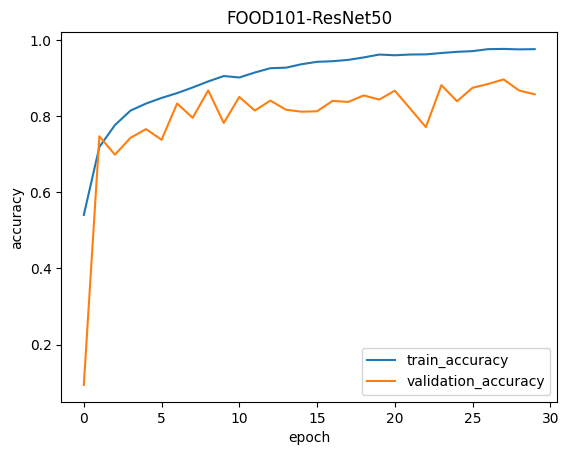

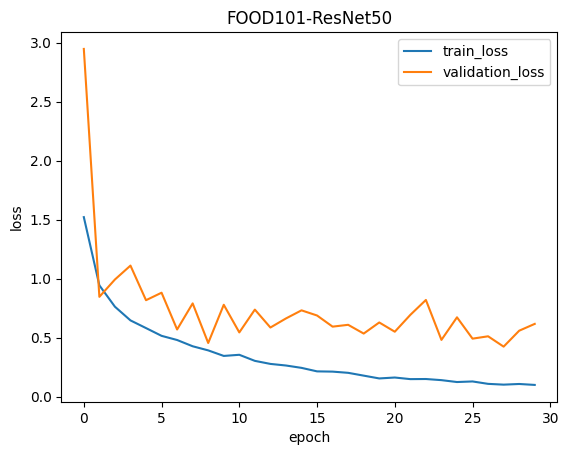

In [ ]:
plot_accuracy(history_11class,'FOOD101-ResNet50')
plot_loss(history_11class,'FOOD101-ResNet50')

In [ ]:
%%time
# Loading the best saved model to make predictions
K.clear_session()
model_best = load_model('best_model_11class.hdf5',compile = False)

CPU times: user 1.94 s, sys: 80.3 ms, total: 2.02 s
Wall time: 1.97 s


1/1 [==============================] - 1s 916ms/step


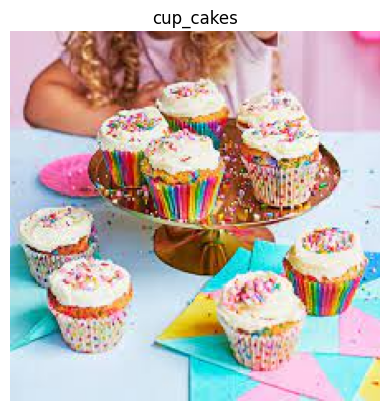

1/1 [==============================] - 0s 33ms/step


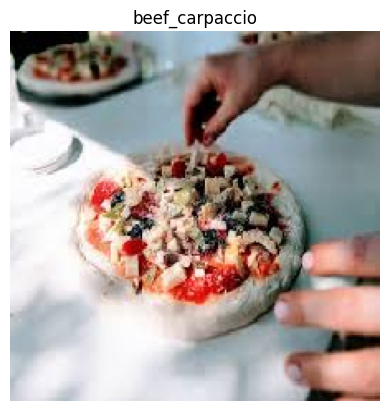

1/1 [==============================] - 0s 23ms/step


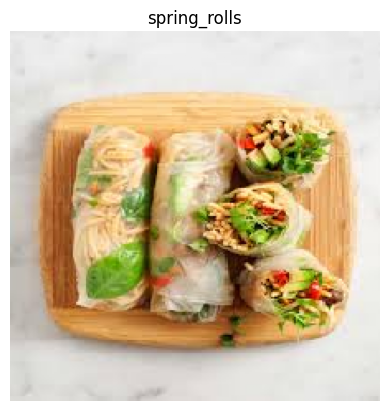

1/1 [==============================] - 0s 22ms/step


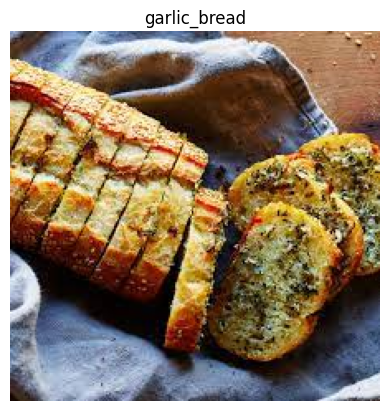

In [ ]:
# Make a list of downloaded images and test the trained model
images = []
images.append('/content/cupcakes.jpeg')
images.append('/content/pizza.jpeg')
images.append('/content/springrolls.jpeg')
images.append('/content/garlicbread.jpeg')
predict_class(model_best, images, True)